In [1]:
import csv
import pandas as pd
from tensorflow import keras
from sklearn.model_selection import train_test_split
import tensorflow as tf
import enum
import matplotlib.pyplot as plt

2022-08-08 19:34:16.670680: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
class BodyPart(enum.Enum):
    
  """Enum representing human body keypoints detected by pose estimation models."""
  NOSE = 0
  LEFT_EYE = 1
  RIGHT_EYE = 2
  LEFT_EAR = 3
  RIGHT_EAR = 4
  LEFT_SHOULDER = 5
  RIGHT_SHOULDER = 6
  LEFT_ELBOW = 7
  RIGHT_ELBOW = 8
  LEFT_WRIST = 9
  RIGHT_WRIST = 10
  LEFT_HIP = 11
  RIGHT_HIP = 12
  LEFT_KNEE = 13
  RIGHT_KNEE = 14
  LEFT_ANKLE = 15
  RIGHT_ANKLE = 16

In [3]:
# loading final csv file
def load_csv(csv_path):
    df = pd.read_csv(csv_path)
    df.drop(['filename'],axis=1, inplace=True)
    classes = df.pop('class_name').unique()
    y = df.pop('class_no')
    
    X = df.astype('float64')
    y = keras.utils.to_categorical(y)
    
    return X, y, classes

def get_center_point(landmarks, left_bodypart, right_bodypart):
    """Calculates the center point of the two given landmarks."""
    left = tf.gather(landmarks, left_bodypart.value, axis=1)
    right = tf.gather(landmarks, right_bodypart.value, axis=1)
    center = left * 0.5 + right * 0.5
    return center

def get_pose_size(landmarks, torso_size_multiplier=2.5):
    """Calculates pose size.
    It is the maximum of two values:
    * Torso size multiplied by `torso_size_multiplier`
    * Maximum distance from pose center to any pose landmark
    """
    # Hips center
    hips_center = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                 BodyPart.RIGHT_HIP)

    # Shoulders center
    shoulders_center = get_center_point(landmarks, BodyPart.LEFT_SHOULDER,
                                      BodyPart.RIGHT_SHOULDER)

    # Torso size as the minimum body size
    torso_size = tf.linalg.norm(shoulders_center - hips_center)
    # Pose center
    pose_center_new = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                     BodyPart.RIGHT_HIP)
    pose_center_new = tf.expand_dims(pose_center_new, axis=1)
    # Broadcast the pose center to the same size as the landmark vector to
    # perform substraction
    pose_center_new = tf.broadcast_to(pose_center_new,
                                    [tf.size(landmarks) // (17*2), 17, 2])

    # Dist to pose center
    d = tf.gather(landmarks - pose_center_new, 0, axis=0,
                name="dist_to_pose_center")
    # Max dist to pose center
    max_dist = tf.reduce_max(tf.linalg.norm(d, axis=0))

    # Normalize scale
    pose_size = tf.maximum(torso_size * torso_size_multiplier, max_dist)
    return pose_size

def normalize_pose_landmarks(landmarks):
    """Normalizes the landmarks translation by moving the pose center to (0,0) and
    scaling it to a constant pose size.
  """
  # Move landmarks so that the pose center becomes (0,0)
    pose_center = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                 BodyPart.RIGHT_HIP)

    pose_center = tf.expand_dims(pose_center, axis=1)
    # Broadcast the pose center to the same size as the landmark vector to perform
    # substraction
    pose_center = tf.broadcast_to(pose_center, 
                                [tf.size(landmarks) // (17*2), 17, 2])
    landmarks = landmarks - pose_center

    # Scale the landmarks to a constant pose size
    pose_size = get_pose_size(landmarks)
    landmarks /= pose_size
    return landmarks

def landmarks_to_embedding(landmarks_and_scores):
    """Converts the input landmarks into a pose embedding."""
    # Reshape the flat input into a matrix with shape=(17, 3)
    reshaped_inputs = keras.layers.Reshape((17, 3))(landmarks_and_scores)

    # Normalize landmarks 2D
    landmarks = normalize_pose_landmarks(reshaped_inputs[:, :, :2])
    # Flatten the normalized landmark coordinates into a vector
    embedding = keras.layers.Flatten()(landmarks)
    return embedding

def preprocess_data(X_train):
    processed_X_train = []
    for i in range(X_train.shape[0]):
        embedding = landmarks_to_embedding(tf.reshape(tf.convert_to_tensor(X_train.iloc[i]), (1, 51)))
        processed_X_train.append(tf.reshape(embedding, (34)))
    return tf.convert_to_tensor(processed_X_train)

In [4]:
X, y, class_names = load_csv('5_train_data.csv')
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15,random_state=42,shuffle=True)

processed_X_train = preprocess_data(X_train)
processed_X_val =  preprocess_data(X_val)

2022-08-08 19:34:21.560881: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-08-08 19:34:21.560984: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: molpro-Precision-7820-Tower
2022-08-08 19:34:21.561002: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: molpro-Precision-7820-Tower
2022-08-08 19:34:21.561273: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 510.85.2
2022-08-08 19:34:21.561330: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 510.73.8
2022-08-08 19:34:21.561346: E tensorflow/stream_executor/cuda/cuda_diagnostics.cc:313] kernel version 510.73.8 does not match DSO version 510.85.2 -- cannot find working devices in this configuration
2022-08-08 19:34:21.563842: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with o

In [5]:
processed_X_train[0]

<tf.Tensor: shape=(34,), dtype=float32, numpy=
array([-0.30266178, -0.10273664, -0.31454343, -0.090179  , -0.3208739 ,
       -0.09219626, -0.29532292, -0.04446179, -0.31449708, -0.05958937,
       -0.21930623,  0.00322091, -0.24951403, -0.0993446 , -0.12707973,
        0.13246061, -0.29923582, -0.22680241, -0.03060166,  0.09343304,
       -0.36996493, -0.3400494 ,  0.00658779,  0.02705543, -0.00658774,
       -0.02705543,  0.18889454, -0.06828478,  0.09388053, -0.20846811,
        0.25460383,  0.16649613,  0.23898791, -0.35363185], dtype=float32)>

MODEL : Dense + Dropout 

- Dense : The dense layer is a neural network layer that is connected deeply, which means each neuron in the dense layer receives input from all neurons of its previous layer. The dense layer is found to be the most commonly used layer in the models.In the background, the dense layer performs a matrix-vector multiplication. The values used in the matrix are actually parameters that can be trained and updated with the help of backpropagation

- Dropout : Dropout Layer is one of the most popular regularization techniques to reduce overfitting in the deep learning models. Overfitting in the model occurs when it shows more accuracy on the training data but less accuracy on the test data or unseen data

In [6]:
inputs = tf.keras.Input(shape=(34))
layer = keras.layers.Dense(128, activation=tf.nn.relu6)(inputs)
layer = keras.layers.Dropout(0.5)(layer)
layer = keras.layers.Dense(64, activation=tf.nn.relu6)(layer)
layer = keras.layers.Dropout(0.5)(layer)
outputs = keras.layers.Dense(len(class_names), activation="softmax")(layer)

In [7]:
Stroke_classifier = keras.Model(inputs, outputs)


Stroke_classifier.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Stroke_classifier.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 34)]              0         
                                                                 
 dense (Dense)               (None, 128)               4480      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 5)                 325       
                                                                 
Total params: 13,061
Trainable params: 13,061
Non-trainable p

In [8]:
# Add a checkpoint callback to store the checkpoint that has the highest
# validation accuracy.
checkpoint_path = "weights.best.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
earlystopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                              patience=20)

# Start training
print('--------------TRAINING----------------')
history = Stroke_classifier.fit(processed_X_train, y_train,
                    epochs=200,
                    batch_size=16,
                    validation_data=(processed_X_val, y_val),
                    callbacks=[checkpoint, earlystopping])

--------------TRAINING----------------
Epoch 1/200
266/275 [============================>.] - ETA: 0s - loss: 1.3946 - accuracy: 0.4319
Epoch 1: val_accuracy improved from -inf to 0.58634, saving model to weights.best.hdf5
275/275 [==============================] - 2s 4ms/step - loss: 1.3874 - accuracy: 0.4374 - val_loss: 1.1539 - val_accuracy: 0.5863
Epoch 2/200
272/275 [============================>.] - ETA: 0s - loss: 1.1748 - accuracy: 0.5616
Epoch 2: val_accuracy improved from 0.58634 to 0.60825, saving model to weights.best.hdf5
275/275 [==============================] - 1s 3ms/step - loss: 1.1751 - accuracy: 0.5614 - val_loss: 1.0255 - val_accuracy: 0.6082
Epoch 3/200
261/275 [===========================>..] - ETA: 0s - loss: 1.0825 - accuracy: 0.5910
Epoch 3: val_accuracy improved from 0.60825 to 0.60954, saving model to weights.best.hdf5
275/275 [==============================] - 1s 4ms/step - loss: 1.0874 - accuracy: 0.5885 - val_loss: 0.9913 - val_accuracy: 0.6095
Epoch 4/20

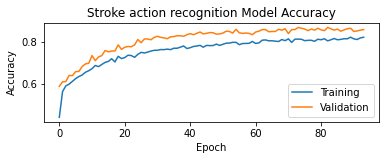

In [9]:
# summarize history for accuracy

plt.subplot(211)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Stroke action recognition Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')

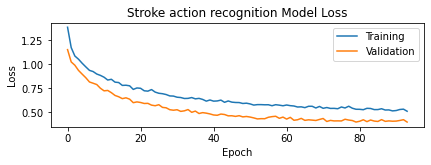

In [10]:
# summarize history for loss

plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Stroke action recognition Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.tight_layout()

In [11]:
Stroke_classifier.save("5_model.h5")